# LSTM for Batch learning 

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.autograd import Variable
from skorch.callbacks import EarlyStopping
import torch.optim as optim
from skorch import NeuralNetRegressor

import optuna

c:\Users\akilh\OneDrive\Bureau\TELECOM_3A\DataScience-X\DataStreamProcessing\project\StockMarketPrediction\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = pd.read_csv('./Bdata/BTCUSDT.csv', index_col=0)
df.head(5)

,date,open,high,low,close,volume,SMA_20,EMA_50,RSI,stoch_k,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean,rolling_std,target
19,2025-01-20 01:10:00,100236.02,100420.14,99921.18,100214.58,364.79680,100694.7950,100180.720153,44.404996,31.234520,...,99883.55,99794.51,100095.64,99721.95,100762.71,99857.92,100892.00,100070.86000,339.272273,0.004445
20,2025-01-20 01:15:00,100214.58,100459.06,99910.73,100200.29,233.97171,100721.4515,100181.487598,40.604029,32.534346,...,100236.02,99883.55,99794.51,100095.64,99721.95,100762.71,99857.92,100113.65625,330.042477,-0.001178
21,2025-01-20 01:20:00,100200.29,100203.08,99745.00,100162.97,228.33874,100669.0465,100180.761418,38.412483,30.667207,...,100214.58,100236.02,99883.55,99794.51,100095.64,99721.95,100762.71,100038.68875,206.569366,0.002098
22,2025-01-20 01:25:00,100162.97,100518.05,100009.62,100320.00,279.41480,100596.0700,100186.221754,42.990889,38.523499,...,100200.29,100214.58,100236.02,99883.55,99794.51,100095.64,99721.95,100113.44500,182.365774,-0.001425
23,2025-01-20 01:30:00,100320.00,100656.84,100113.20,100584.00,345.33619,100554.5495,100201.820901,42.098164,51.731556,...,100162.97,100200.29,100214.58,100236.02,99883.55,99794.51,100095.64,100174.49000,246.139909,0.001082


In [ ]:
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

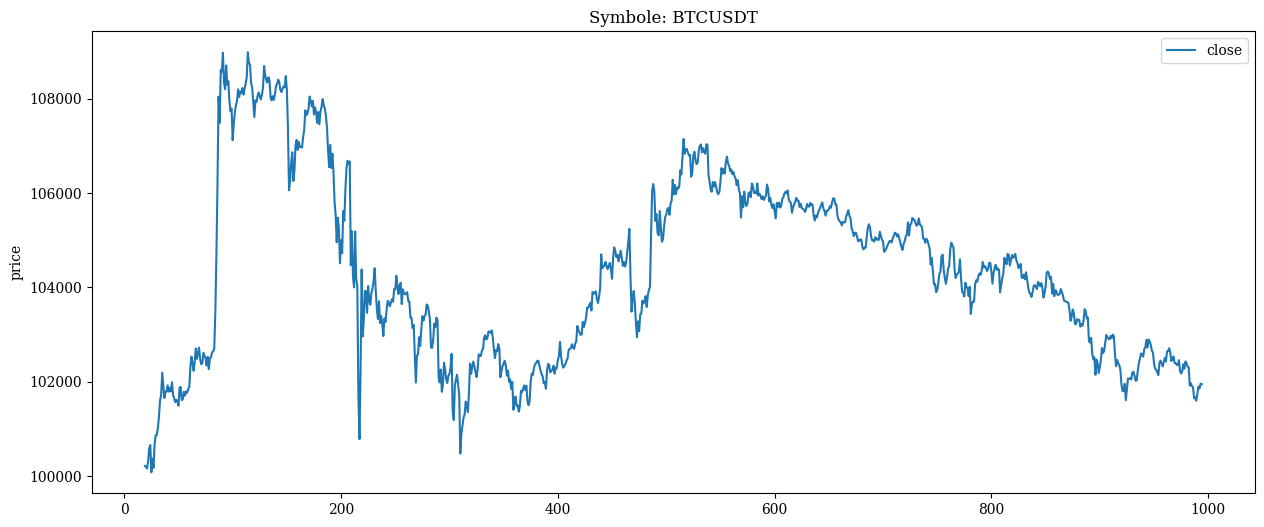

In [8]:
df[['close']].plot(figsize=(15, 6))
plt.ylabel("price")
plt.title("Symbole: BTCUSDT")
plt.show()

In [10]:
X = df[[feat for feat in df.columns if feat not in ['date', 'close', 'start_date', 'end_date']]]
y = df['close']

In [11]:
X.columns

Index(['open', 'high', 'low', 'volume', 'SMA_20', 'EMA_50', 'RSI', 'stoch_k',
       'stoch_d', 'BB_upper', 'BB_middle', 'BB_lower', 'ATR', 'ROC', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'rolling_mean', 'rolling_std', 'target'],
      dtype='object')

In [12]:
X.head(5)

,open,high,low,volume,SMA_20,EMA_50,RSI,stoch_k,stoch_d,BB_upper,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean,rolling_std,target
19,100236.02,100420.14,99921.18,364.79680,100694.7950,100180.720153,44.404996,31.234520,26.384391,102068.984359,...,99883.55,99794.51,100095.64,99721.95,100762.71,99857.92,100892.00,100070.86000,339.272273,0.004445
20,100214.58,100459.06,99910.73,233.97171,100721.4515,100181.487598,40.604029,32.534346,32.003681,102030.864626,...,100236.02,99883.55,99794.51,100095.64,99721.95,100762.71,99857.92,100113.65625,330.042477,-0.001178
21,100200.29,100203.08,99745.00,228.33874,100669.0465,100180.761418,38.412483,30.667207,31.478691,101979.845583,...,100214.58,100236.02,99883.55,99794.51,100095.64,99721.95,100762.71,100038.68875,206.569366,0.002098
22,100162.97,100518.05,100009.62,279.41480,100596.0700,100186.221754,42.990889,38.523499,33.908351,101805.121049,...,100200.29,100214.58,100236.02,99883.55,99794.51,100095.64,99721.95,100113.44500,182.365774,-0.001425
23,100320.00,100656.84,100113.20,345.33619,100554.5495,100201.820901,42.098164,51.731556,40.307421,101700.669488,...,100162.97,100200.29,100214.58,100236.02,99883.55,99794.51,100095.64,100174.49000,246.139909,0.001082


In [16]:
# Splitting data into training and test sets initially
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

numeric_features = X.columns

numeric_transformer = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.columns)
    ])

# Applying transformations separately
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [17]:
X_train_transformed

array([[-2.17938328, -2.18643128, -2.23164808, ..., -2.27176011,
         0.24492231,  0.62569635],
       [-2.19007895, -2.16698574, -2.23683897, ..., -2.25024865,
         0.21086808, -0.21797821],
       [-2.19720774, -2.29488064, -2.31916301, ..., -2.28793093,
        -0.24469798,  0.27354558],
       ...,
       [-0.09523344, -0.18247638, -0.14224758, ..., -0.10289869,
        -0.67991002, -0.42209947],
       [-0.12915629, -0.10117684, -0.06965955, ..., -0.0964893 ,
        -0.70720142, -0.17059585],
       [-0.10211778, -0.13575113, -0.0326875 , ..., -0.08024308,
        -0.74170407, -0.19724348]], shape=(780, 25))

In [18]:
# Recreate DataFrames with feature names for interpretability
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=numeric_features, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=numeric_features, index=X_test.index)

In [19]:
X_train_transformed_df

,open,high,low,volume,SMA_20,EMA_50,RSI,stoch_k,stoch_d,BB_upper,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean,rolling_std,target
19,-2.179383,-2.186431,-2.231648,0.631458,-1.962927,-2.311609,-0.457398,-0.822895,-1.080007,-1.578043,...,-2.344105,-2.376827,-2.217905,-2.390612,-1.872089,-2.305344,-1.793646,-2.271760,0.244922,0.625696
20,-2.190079,-2.166986,-2.236839,0.164122,-1.949403,-2.311197,-0.706156,-0.776113,-0.860409,-1.596036,...,-2.168885,-2.332724,-2.366589,-2.206778,-2.382932,-1.862757,-2.298434,-2.250249,0.210868,-0.217978
21,-2.197208,-2.294881,-2.319163,0.144000,-1.975990,-2.311587,-0.849583,-0.843313,-0.880925,-1.620118,...,-2.179544,-2.158139,-2.322625,-2.354916,-2.199511,-2.371855,-1.856759,-2.287931,-0.244698,0.273546
22,-2.215825,-2.137513,-2.187717,0.326455,-2.013015,-2.308651,-0.549946,-0.560561,-0.785976,-1.702590,...,-2.186648,-2.168758,-2.148591,-2.311114,-2.347317,-2.189061,-2.364808,-2.250355,-0.333999,-0.254996
23,-2.137489,-2.068169,-2.136265,0.561940,-2.034080,-2.300263,-0.608371,-0.085196,-0.535904,-1.751892,...,-2.205200,-2.175836,-2.159177,-2.137719,-2.303613,-2.336361,-2.182390,-2.219671,-0.098699,0.121109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,-0.089147,-0.106548,-0.011497,-0.489959,-0.256597,-0.086824,0.645602,1.214228,1.430075,-0.358030,...,-0.030235,-0.121718,-0.158777,-0.139459,-0.161166,-0.218552,-0.203145,-0.127224,-0.521369,0.052422
795,-0.076770,-0.155012,-0.023324,-0.444877,-0.241269,-0.084810,2.205202,1.095714,1.253059,-0.339915,...,-0.085962,-0.027236,-0.118600,-0.155211,-0.136841,-0.157681,-0.215939,-0.109016,-0.635179,-0.173597
796,-0.095233,-0.182476,-0.142248,-0.240759,-0.235014,-0.084308,1.735102,0.740793,1.107239,-0.328945,...,-0.073629,-0.082761,-0.024416,-0.115182,-0.152557,-0.133438,-0.155193,-0.102899,-0.679910,-0.422099
797,-0.129156,-0.101177,-0.069660,-0.321477,-0.225057,-0.082682,1.735032,0.931545,1.004924,-0.313818,...,-0.092027,-0.070472,-0.079766,-0.021344,-0.112618,-0.149101,-0.131001,-0.096489,-0.707201,-0.170596


In [20]:
print('x_train.shape = ',X_train_transformed_df.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',X_test_transformed_df.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (780, 25)
y_train.shape =  (780,)
x_test.shape =  (196, 25)
y_test.shape =  (196,)


In [21]:
X_train_tensor = torch.tensor(X_train_transformed_df.values.astype(float)).float().unsqueeze(1)
X_test_tensor = torch.tensor(X_test_transformed_df.values.astype(float)).float().unsqueeze(1)

y_train_tensor = torch.tensor(y_train.values.astype(float)).float()
y_test_tensor = torch.tensor(y_test.values.astype(float)).float()

In [28]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        batch_size = x.size(0) # Extract batch size from input
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        out, (h0, c0) = self.lstm(x, (h0.detach(), c0.detach()))

        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :]) # Select the output of the last time step
        
        return out.squeeze()


In [29]:
net = NeuralNetRegressor(
    module=LSTM,
    module__input_size=X_train_transformed_df.shape[1],  # Number of features
    module__hidden_size=128,
    module__num_layers=2,
    module__output_size=1,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__lr=0.01,
    batch_size=2,
    max_epochs=100,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

net.fit(X_train_tensor, y_train_tensor)

  epoch        train_loss        valid_loss     dur
-------  ----------------  ----------------  ------
      1  10876274983.3846  11026892694.9744  4.8724
      2  10810132827.8974  10961585887.1795  3.3680
      3  10745798816.8205  10897078245.7436  5.7105
      4  10682055148.3077  10833029146.2564  3.0349
      5  10618708204.3077  10769332814.7692  3.2872
      6  10555682530.4615  10705934414.7692  3.0074
      7  10492938390.9744  10642803856.4103  3.6115
      8  10430451364.1026  10579921158.5641  4.8942
      9  10368204521.0256  10517273061.7436  3.9893
     10  10306185688.6154  10454849509.7436  3.8178
     11  10244385821.5385  10392638805.3333  3.2902
     12  10182798040.6154  10330639491.2821  3.1077
     13  10121416700.7179  10268843126.1538  3.1446
     14  10060237869.9487  10207248095.1795  5.2911
     15  9999257504.8205  10145849698.4615  3.0877
     16  9938473885.5385  10084648277.3333  3.1197
     17  9877884704.8205  10023638646.1538  3.2174
     18  981748

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=LSTM(
    (lstm): LSTM(25, 128, num_layers=2, batch_first=True)
    (fc): Linear(in_features=128, out_features=1, bias=True)
  ),
)

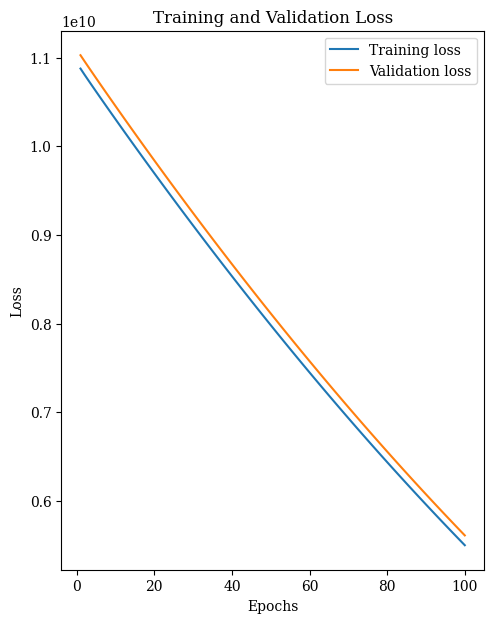

In [30]:
# Access training history
history = net.history_

# Extract training and validation loss
train_loss = history[:, 'train_loss']
valid_loss = history[:, 'valid_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, valid_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

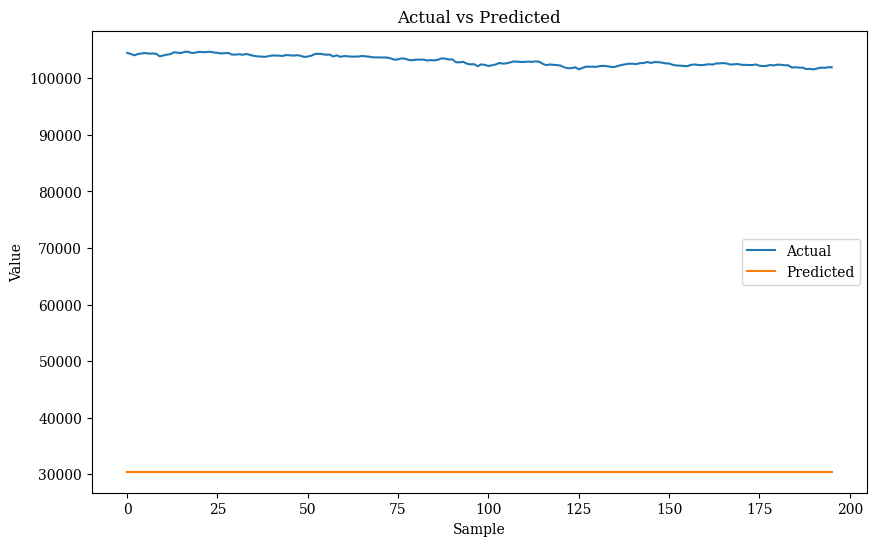

In [32]:
# Obtain predictions on the test set
y_pred = net.predict(X_test_tensor)

# Plot predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [33]:
# Predictions on the training set
y_train_pred = net.predict(X_train_tensor)

# Calculate mean squared error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate mean squared error (MSE) for test set
mse_test = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (MSE) - Training Set:", mse_train)
print("Mean Squared Error (MSE) - Test Set:", mse_test)


Mean Squared Error (MSE) - Training Set: 5506184682.308301
Mean Squared Error (MSE) - Test Set: 5286109278.927093


### Optuna - Hyperparameter tuning

In [18]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 16, 64)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_float('lr', 1e-5, 1e-2)
    
    # Construct the LSTM model with suggested hyperparameters
    class LSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, output_size):
            super(LSTM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
        
        def forward(self, x):
            batch_size = x.size(0)
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
            
            out, _ = self.lstm(x, (h0, c0))
            out, (h0, c0) = self.lstm(x, (h0.detach(), c0.detach()))
            
            out = self.fc(out[:, -1, :])
            
            return out
    
    # Construct the NeuralNetRegressor with suggested hyperparameters
    net = NeuralNetRegressor(
        module=LSTM,
        module__input_size=X_train_transformed_df.shape[1],
        module__hidden_size=hidden_size,
        module__num_layers=num_layers,
        module__output_size=1,
        criterion=nn.MSELoss,
        optimizer=optim.Adam,
        optimizer__lr=lr,
        batch_size=32,
        max_epochs=100,
        verbose=0,
        callbacks=[EarlyStopping(patience=5)],
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    
    # Train the model
    net.fit(X_train_tensor, y_train_tensor)
    
    # Return the validation loss for Optuna to minimize
    return net.history[-1]['valid_loss']


# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run Optuna optimization
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2025-01-22 23:13:53,128] A new study created in memory with name: no-name-1c57a482-51cb-43d5-9551-810adf0089f1
c:\Users\akilh\OneDrive\Bureau\TELECOM_3A\DataScience-X\DataStreamProcessing\project\StockMarketPrediction\myvenv\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-01-22 23:14:16,739] Trial 0 finished with value: 596709120.0 and parameters: {'hidden_size': 17, 'num_layers': 3, 'lr': 0.0054257018064485085}. Best is trial 0 with value: 596709120.0.
[I 2025-01-22 23:14:17,405] Trial 1 finished with value: 603571212.8 and parameters: {'hidden_size': 16, 'num_layers': 1, 'lr': 0.001720131010565752}. Best is trial 0 with value: 596709120.0.
[I 2025-01-22 23:14:35,053] Trial 2 finished with value: 5812448

Best Hyperparameters: {'hidden_size': 57, 'num_layers': 2, 'lr': 0.008725837377673568}


In [19]:
print("Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Best trial:
  Params: 
    hidden_size: 57
    num_layers: 2
    lr: 0.008725837377673568


  epoch       train_loss      valid_loss     dur
-------  ---------------  --------------  ------
      1  1612517590.4000  603344038.4000  0.2990
      2  1611712923.2000  602724563.2000  1.3536
      3  1610809745.6000  602238656.0000  0.1899
      4  1610107433.6000  601793696.0000  0.2005
      5  1609462142.4000  601379846.4000  0.1911
      6  1608851956.8000  600984492.8000  0.2009
      7  1608263193.6000  600600876.8000  0.2052
      8  1607688689.6000  600225254.4000  0.2000
      9  1607124112.0000  599855468.8000  0.2000
     10  1606567129.6000  599490169.6000  0.2200
     11  1606015828.8000  599128345.6000  0.2100
     12  1605469363.2000  598769414.4000  0.2168
     13  1604926624.0000  598412838.4000  0.1978
     14  1604387097.6000  598058265.6000  0.1848
     15  1603850308.8000  597705420.8000  0.1984
     16  1603315886.4000  597354131.2000  0.1712
     17  1602783526.4000  597004076.8000  0.1800
     18  1602252929.6000  596655244.8000  0.1732
     19  1601723979.

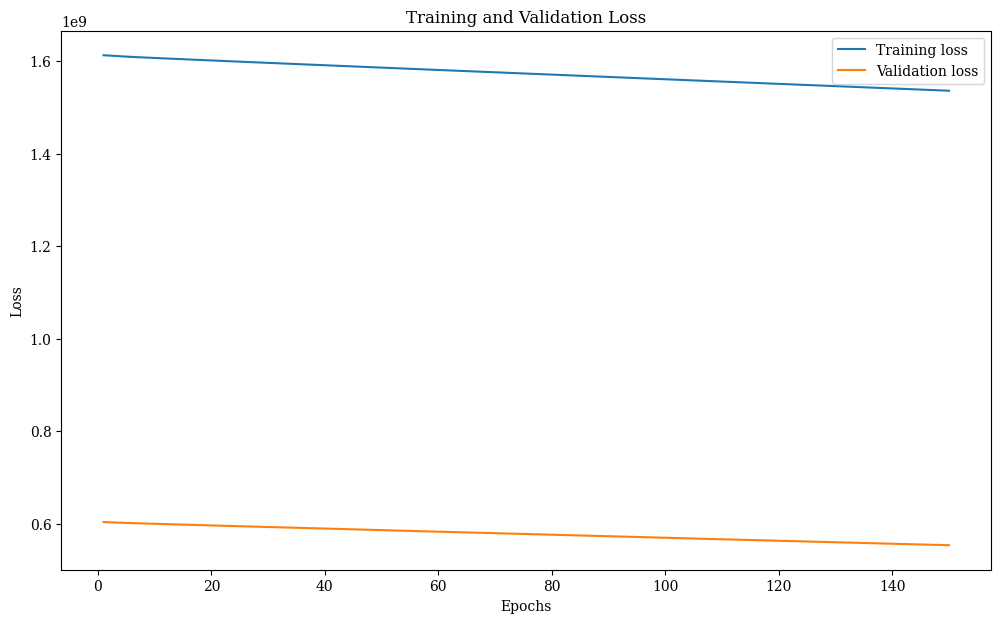

In [20]:
# Get the best hyperparameters
best_params = study.best_params

# Construct the LSTM model with the best hyperparameters
best_model = NeuralNetRegressor(
    module=LSTM,
    module__input_size=X_train_transformed_df.shape[1],
    module__hidden_size=best_params['hidden_size'],
    module__num_layers=best_params['num_layers'],
    module__output_size=1,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__lr=best_params['lr'],
    batch_size=32,
    max_epochs=150,
    callbacks=[EarlyStopping(patience=5)],
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Fit the best model with the entire training dataset
best_model.fit(X_train_tensor, y_train_tensor)

# Plot training and validation loss
history = best_model.history
train_loss = history[:, 'train_loss']
valid_loss = history[:, 'valid_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, valid_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


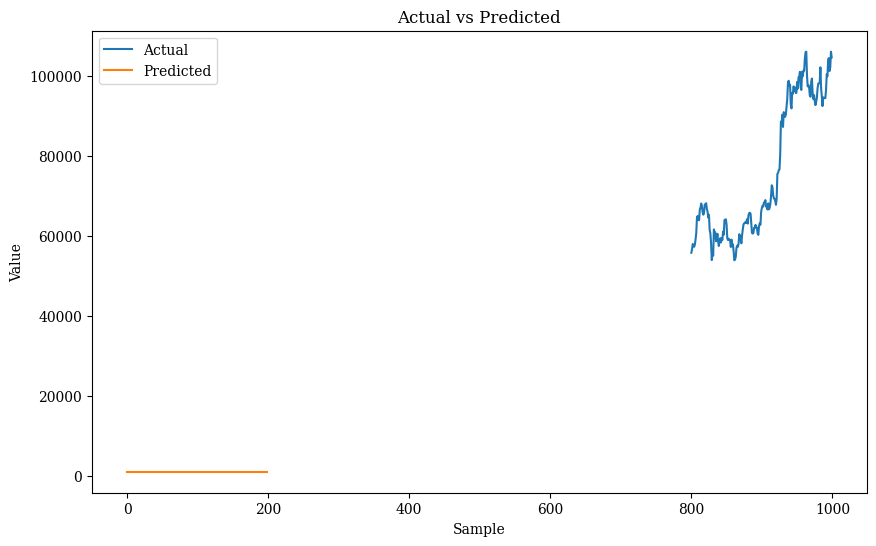

In [21]:
# Obtain predictions on the test set using the best model found by Optuna
y_pred = best_model.predict(X_test_tensor)

# Plot predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [22]:
# Predictions on the training set
y_train_pred = best_model.predict(X_train_tensor)

# Calculate mean squared error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate mean squared error (MSE) for test set
mse_test = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (MSE) - Training Set:", mse_train)
print("Mean Squared Error (MSE) - Test Set:", mse_test)


Mean Squared Error (MSE) - Training Set: 1339083046.1315665
Mean Squared Error (MSE) - Test Set: 5832251913.382119
